In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scvelo as scv
from scvi.nn import Encoder, FCLayers
import anndata
import pandas as pd
import scipy.sparse as sp
import scanpy as sc
from tqdm import tqdm
from torch.distributions import Poisson, NegativeBinomial, kl_divergence, Normal

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [115]:
def preprocess_and_initialize_scvelo(
    adata, 
    isoform_key="isoform_counts", 
    proportion_key = "proportion",
    min_isoform_counts=10, 
    min_cell_counts = 10,
    min_isoform_prop=0.05, 
    n_top_genes=800,
    n_top_splicing = 500,
    min_cells_spanning = 5,
    isoform_delimiter="_",
    normalized = False
):
    """
    Prefilter Isoforms and Genes.
    1. Filter cells, remove low total counts cells.
    2. Filter Isoforms: Remove low expression and low global proportion isoforms.
    3. Filter Genes, keep highly variable genes and isoform proportion variable genes.
    4. Run scVelo dynamical mode.
    5. Return initialization parameters for VAE.
    
    Parameters:
    adata: including layers['unspliced'] and obsm[isoform_key]
    isoform_key: key of isoform count in adata.obsm
    """

    if adata.X is None:
        adata.X = adata.layers['spliced'] + adata.layers['unspliced']

    # 1. Filter cells, remove low total counts cells.
    initial_cell_count = adata.n_obs
    sc.pp.filter_cells(adata, min_counts=min_cell_counts)
    print(f"Filtered cells from {initial_cell_count} to {adata.n_obs} (min_counts={min_cell_counts})")

    # 2. Filter Isoforms: Remove low expression and low global proportion isoforms.
    iso_df = adata.obsm[isoform_key]
    iso_df = iso_df.loc[adata.obs_names]
    isoform_names = iso_df.columns
    try:
        gene_map = pd.Series([x.rsplit(isoform_delimiter, 1)[0] for x in isoform_names], index=isoform_names)
    except Exception as e:
        raise ValueError(f"Error parsing isoform with names '{isoform_delimiter}'. Error: {e}")

    iso_sum = iso_df.sum(axis=0)
    keep_mask_count = iso_sum >= min_isoform_counts

    iso_prop = adata.obsm[proportion_key]
    high_prop_mask = iso_prop >= min_isoform_prop
    cells_passing_count = high_prop_mask.sum(axis=0)
    keep_mask_prop = cells_passing_count >= min_cells_spanning
    keep_isoforms = keep_mask_count & keep_mask_prop

    filtered_iso_df = iso_df.loc[:, keep_isoforms]
    adata.obsm[isoform_key] = filtered_iso_df
    filtered_prop_df = iso_prop.loc[:, keep_isoforms]
    adata.obsm[proportion_key] = filtered_prop_df

    print(f"Filtered isoforms from {iso_df.shape[1]} to {filtered_iso_df.shape[1]} based on isoform expression and global proportion.")

    remaining_isoforms = gene_map[keep_isoforms.values]
    new_counts = pd.Series(remaining_isoforms).value_counts(sort=False)
    adata.var['filtered_n_isoforms'] = 0
    genes_to_update = new_counts.index.intersection(adata.var_names)
    adata.var.loc[genes_to_update, 'filtered_n_isoforms'] = new_counts[genes_to_update]

    # Recalculate proportion dataframe based on remaining isoforms
    current_iso_cols = filtered_iso_df.columns
    current_gene_map = pd.Series([x.rsplit(isoform_delimiter, 1)[0] for x in current_iso_cols], index=current_iso_cols)
    new_gene_counts_df = filtered_iso_df.groupby(current_gene_map.values, axis=1).sum()
    full_spliced_df = pd.DataFrame(
        adata.layers['spliced'], 
        index=adata.obs_names, 
        columns=adata.var_names
    )
    full_spliced_df.update(new_gene_counts_df)
    adata.layers['spliced'] = full_spliced_df.values
    if not normalized:
        adata.X = adata.layers['spliced'] + adata.layers['unspliced']

    gene_ids_per_col = current_gene_map[filtered_iso_df.columns]
    gene_counts_expanded = new_gene_counts_df.loc[:, gene_ids_per_col]
    gene_counts_expanded.columns = filtered_iso_df.columns 
 
    new_props = filtered_iso_df / (gene_counts_expanded)
    adata.obsm[proportion_key] = new_props
      
    # 3. Filter Genes, keep highly variable genes and isoform proportion variable genes.
    adata_hvg = adata.copy()
    if not normalized:
        sc.pp.normalize_total(adata_hvg)
        sc.pp.log1p(adata_hvg)
        sc.pp.highly_variable_genes(adata_hvg, n_top_genes=n_top_genes, flavor='seurat')
        hvg_genes = set(adata_hvg.var_names[adata_hvg.var['highly_variable']])
    else:
        sc.pp.highly_variable_genes(adata_hvg, n_top_genes=n_top_genes, flavor='seurat')
        hvg_genes = set(adata_hvg.var_names[adata_hvg.var['highly_variable']])
    
    print(f"Found {len(hvg_genes)} expression HVGs.")

    iso_variances = new_props.var(axis=0)
    gene_splicing_scores = iso_variances.groupby(current_gene_map.values, sort=False).mean()
    multi_iso_genes = adata.var_names[adata.var['filtered_n_isoforms'] > 1]
    valid_genes = gene_splicing_scores.index.intersection(multi_iso_genes)
    final_scores = gene_splicing_scores.loc[valid_genes]

    if not final_scores.empty:
        top_splicing_genes = final_scores.sort_values(ascending=False).head(n_top_splicing).index.tolist()
        high_splice_genes = set(top_splicing_genes)
    else:
        high_splice_genes = set()
        
    print(f"Identified {len(high_splice_genes)} genes with high splicing variance.")
    
    final_genes_set = (hvg_genes | high_splice_genes)
    final_genes = [gene for gene in adata.var_names if gene in final_genes_set]
    adata = adata[:, final_genes].copy()

    is_isoform_kept = current_gene_map.isin(final_genes_set)
    final_iso_counts = filtered_iso_df.loc[:, is_isoform_kept]
    final_iso_props  = new_props.loc[:, is_isoform_kept]
    adata.obsm[isoform_key] = final_iso_counts
    adata.obsm[proportion_key] = final_iso_props
    
    # 4. Run scVelo dynamical mode.
    print("Preparing scVelo results:")
    adata.layers['raw_unspliced'] = adata.layers['unspliced'].copy()
    adata.layers['raw_spliced'] = adata.layers['spliced'].copy()
    if not normalized:
        scv.pp.filter_and_normalize(adata, min_counts=0, min_cells=0, log=True)
        scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    else:
        scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    
    scv.tl.recover_dynamics(adata, var_names='all', n_jobs=-1)
    scv.tl.latent_time(adata)

    n_total = adata.n_vars
    n_fitted = adata.var['fit_alpha'].notnull().sum()
    print(f"Dynamics recovered for {n_fitted}/{n_total} genes.")

    return adata

In [116]:
adata = anndata.read_h5ad('../../test_simulated_data_continuous_0.h5ad')
print(adata)
adata = preprocess_and_initialize_scvelo(
    adata, 
    isoform_key="isoform_counts", 
    proportion_key = "proportion",
    min_isoform_counts=10, 
    min_cell_counts = 10,
    min_isoform_prop=0.05, 
    n_top_genes=800,
    n_top_splicing = 500,
    min_cells_spanning = 10,
    isoform_delimiter="_",
    normalized = False
)

AnnData object with n_obs × n_vars = 2000 × 1000
    obs: 'cell_state', 'pseudotime'
    var: 'gene_category', 'n_isoforms'
    uns: 'proportions_ground_truth', 'proportions_observed', 'spliced_isoform_counts'
    obsm: 'isoform_counts', 'proportion'
    layers: 'alpha', 'beta', 'gamma', 'spliced', 'unspliced'
Filtered cells from 2000 to 2000 (min_counts=10)
Filtered isoforms from 3468 to 3468 based on isoform expression and global proportion.
Found 800 expression HVGs.
Identified 500 genes with high splicing variance.
Preparing scVelo results:
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors


c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
C:\Users\shizh\AppData\Local\Temp\ipykernel_37472\3109797284.py:130: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\preprocessing\moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\preprocessing\neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and

    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 32/32 cores)
    finished (0:00:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Dynamics recovered for 886/886 genes.


In [118]:
print(adata)
print(adata.layers['raw_unspliced'])

AnnData object with n_obs × n_vars = 2000 × 886
    obs: 'cell_state', 'pseudotime', 'n_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_category', 'n_isoforms', 'filtered_n_isoforms', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'proportions_ground_truth', 'proportions_observed', 'spliced_isoform_counts', 'log1p', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'isoform_counts', 'proportion', 'X_pca'
    varm: 'PCs', 'loss'
    layers: 'alpha', 'beta', 'gamma', 'spliced', 'unspliced', 'raw_unspliced', 'raw_spliced', 'Ms', 'Mu', 'fit_t', 'fit_t

In [119]:
class IsoDataset(Dataset):
    def __init__(self, adata):
        # Get Unspliced counts (G genes)
        U = adata.layers["raw_unspliced"]
        if sp.issparse(U):
            U = U.toarray()
        
        # Get Isoform counts (I isoforms)
        # Assume that adata.obsm["isoform_counts"] includes spliced isoform count
        I = adata.obsm["isoform_counts"]
        if hasattr(I, "values"): 
            I = I.values
        if sp.issparse(I):        
            I = I.toarray()
            
        # Merge: Cells x (Genes + Isoforms)
        # Note: the input of the Encoder should be G + I
        X = np.hstack([U, I]).astype(np.float32) 
        self.X = torch.from_numpy(X)
        self.n_cells = self.X.shape[0]
        self.n_genes = U.shape[1]
        self.n_isoforms = I.shape[1]

    def __len__(self):
        return self.n_cells

    def __getitem__(self, idx):
        # Get the data and index
        return self.X[idx], idx

In [80]:
class IsoveloEncoder(Encoder):
    """
    Encodes U (unspliced) and Isoform counts into a latent cell embedding.
    Inherits from scvi.nn.Encoder to leverage its VAE structure.
    """
    def __init__(self, 
                 input_dim:int, 
                 hidden_dim=32, 
                 latent_dim = 128, 
                 n_layers=2, 
                 dropout_rate=0.1, 
                 distribution="normal", 
                 use_batch_norm=True, 
                 use_layer_norm=False,
                 var_activation=nn.Softplus(),
                 activation_fn=nn.ReLU,
                 **kwargs):
        super().__init__(n_input=input_dim, 
                         n_output=latent_dim,
                         n_layers=n_layers,
                         n_hidden=hidden_dim,
                         dropout_rate=dropout_rate,
                         distribution=distribution,
                         use_batch_norm=use_batch_norm,
                         use_layer_norm=use_layer_norm,
                         var_activation=var_activation,
                         activation_fn=activation_fn,
                         **kwargs
                         )

    def forward(self, x: torch.Tensor, *cat_list: torch.Tensor):
        """
        Forward pass.
        :param x: Concatenated tensor of [U, Isoforms]
        :return: A dictionary with 'qz_m', 'qz_v', 'z'
        """
        # Encode x to get latent parameters
        qz_m, qz_v, z = super().forward(x, *cat_list)
        
        return {"qz_m": qz_m, "qz_v": qz_v, "z": z}

In [123]:
def build_encoder_from_adata(adata, **enc_kwargs):
    U = adata.layers["raw_unspliced"]
    g = U.shape[1]
    i = adata.obsm["isoform_counts"].shape[1]
    enc = IsoveloEncoder(input_dim=g + i, **enc_kwargs)
    return enc

In [127]:
class IsoveloDecoder(nn.Module):
    def __init__(self,
                 n_cells: int,
                 n_genes: int,
                 n_isoforms: int,
                 latent_dim: int = 128,
                 hidden_dim: int = 256,
                 # Initialization values provided by scVelo
                 init_time: np.ndarray = None,      # shape: (n_cells, )
                 init_alpha: np.ndarray = None,     # shape: (n_genes, )
                 init_beta_iso: np.ndarray = None,  # shape: (n_isoforms, ) <- (beta_gene * proportion)
                 init_gamma: np.ndarray = None,     # shape: (n_isoforms, ) <- (gamma_gene * proportion)
                 iso_to_gene: np.ndarray = None,    # shape: (n_isoforms, ) gene indices for each isoform
                 device = torch.device):
        
        super().__init__()

        def inverse_softplus(x_np):
            x_safe = np.maximum(x_np, 1e-6)
            return np.log(np.exp(x_safe)-1)

        self.n_genes = n_genes
        self.n_isoforms = n_isoforms
        self.device = device
        if iso_to_gene is None:
            raise ValueError("iso_to_gene mapping is required.")
        self.iso_to_gene = torch.from_numpy(iso_to_gene).long().to(self.device)

        # --- A. Cell Time (t) ---
        # independent parameters, not rely on z (cell * 1)
        self.cell_time = nn.Parameter(torch.randn(n_cells, 1)) 
        if init_time is not None:
            # Initialize with the scvelo output
            self.cell_time.data.copy_(torch.from_numpy(init_time).float().unsqueeze(1))

        # --- B. Gamma (γ) ---
        # independent parameters, not rely on z (1 * isoform)
        self.gamma = nn.Parameter(torch.ones(1, n_isoforms))
        if init_gamma is not None:
            # Initialize with the scvelo output
            inv_gamma = inverse_softplus(init_gamma)
            self.gamma.data.copy_(torch.from_numpy(inv_gamma).float().unsqueeze(0))

        # --- C. Alpha Network (α) ---
        # Input: z -> Output: Alpha (Cell * Gene)
        self.alpha_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.alpha_fc2 = nn.Linear(hidden_dim, n_genes) 
        
        # Initialize the bias of the alpha
        if init_alpha is not None:
            # Initial weights should be small, the initial values should be determined mainly by the scvelo bias
            nn.init.xavier_normal_(self.alpha_fc2.weight, gain=0.01)
            # Set the bias to scvelo output (usually need to get log or inverse softplus, depending on the activation function)
            # Assume that using Softplus activation. For simplicity, set to scvelo output, training will approximate these values
            inv_alpha = inverse_softplus(init_alpha)
            self.alpha_fc2.bias.data.copy_(torch.from_numpy(inv_alpha).float())

        # --- D. Beta Network (β) ---
        # Input: z -> Output: Beta (Cell * Isoform)
        self.beta_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.beta_fc2 = nn.Linear(hidden_dim, n_isoforms) 
        
        # Initialize the bias of the beta
        if init_beta_iso is not None:
            nn.init.xavier_normal_(self.beta_fc2.weight, gain=0.01)
            # Similar with alpha, here it should be isoform level beta
            inv_beta = inverse_softplus(init_beta_iso)
            self.beta_fc2.bias.data.copy_(torch.from_numpy(inv_beta).float())

    def forward(self, z: torch.Tensor, cell_indices = None):
        """
        z: [Batch, Latent_dim]
        cell_indices: [Batch]
        """
        # 1. Get cell time
        if cell_indices is not None:
            t = self.cell_time[cell_indices] # [Batch, 1]
        else:
            t = self.cell_time

        # 2. Get alpha (non-negative)
        h_alpha = F.relu(self.alpha_fc1(z))
        alpha = F.softplus(self.alpha_fc2(h_alpha)) # [Batch, n_genes]

        # 3. Get beta (non-negative)
        h_beta = F.relu(self.beta_fc1(z))
        beta = F.softplus(self.beta_fc2(h_beta))   # [Batch, n_isoforms]

        # 4. Get gamma (non-negative)
        gamma = F.softplus(self.gamma)             # [1, n_isoforms]

        # Compute integrated u_hat and s_hat using analytical ODE solution
        b_size = z.shape[0]

        # Compute beta_total [b_size, n_genes]
        beta_total = torch.zeros(b_size, self.n_genes, device=self.device)
        beta_total.scatter_add_(1, self.iso_to_gene.unsqueeze(0).expand(b_size, -1), beta)
        beta_total = torch.clamp(beta_total, min=1e-6)

        # a_g [b_size, n_genes]
        a_g = alpha / beta_total

        # u_hat [b_size, n_genes]
        exp_bt = torch.exp(-beta_total * t)
        u_hat = a_g * (1 - exp_bt)

        # s_hat [b_size, n_isoforms]
        g_idx = self.iso_to_gene
        a_expand = torch.index_select(a_g, 1, g_idx)  # [b_size, n_isoforms]
        b_expand = torch.index_select(beta_total, 1, g_idx)  # [b_size, n_isoforms]
        gamma_expand = gamma.expand(b_size, -1)  # [b_size, n_isoforms]
        t_expand = t.expand(-1, self.n_isoforms)  # [b_size, n_isoforms]


        denom = gamma_expand - b_expand
        mask = torch.abs(denom) < 1e-6
        s_hat = torch.zeros_like(beta)
        non_mask = ~mask
        s_hat[non_mask] = beta[non_mask] * a_expand[non_mask] * (
            1.0 / gamma_expand[non_mask]
            - torch.exp(-gamma_expand[non_mask] * t_expand[non_mask]) / gamma_expand[non_mask]
            - torch.exp(-b_expand[non_mask] * t_expand[non_mask]) / denom[non_mask]
            + torch.exp(-gamma_expand[non_mask] * t_expand[non_mask]) / denom[non_mask]
        )
        s_hat[mask] = beta[mask] * a_expand[mask] * (
            (1.0 - torch.exp(-b_expand[mask] * t_expand[mask])) / b_expand[mask]
            - t_expand[mask] * torch.exp(-b_expand[mask] * t_expand[mask])
        )

        #### Test
        u_hat = torch.clamp(u_hat, min=0.0)
        s_hat = torch.clamp(s_hat, min=0.0)
        
        return {"cell_time": t, "gene_alpha": alpha, "isoform_beta": beta, "isoform_gamma": gamma,
                "u_hat": u_hat, "s_hat": s_hat}


In [136]:
print(adata)
def build_decoder_from_adata(adata, latent_dim=128, hidden_dim=256, device=torch.device):
    n_cells = adata.n_obs
    n_genes = adata.n_vars
    n_isoforms = adata.obsm['isoform_counts'].shape[1]
    # Get init_time
    init_time = adata.obs['latent_time'].values if 'latent_time' in adata.obs else None
    # Get init_alpha
    init_alpha = adata.var['fit_alpha'].values if 'fit_alpha' in adata.var else None
    # Get gene_map for isoforms
    isoform_names = adata.obsm['isoform_counts'].columns if hasattr(adata.obsm['isoform_counts'], 'columns') else [str(i) for i in range(n_isoforms)]
    isoform_delimiter = "_"
    gene_names = [x.rsplit(isoform_delimiter, 1)[0] for x in isoform_names]
    # gene_idx_for_iso
    gene_to_idx = {g: i for i, g in enumerate(adata.var_names)}
    iso_to_gene_idx = np.array([gene_to_idx[g] for g in gene_names])

    adata.uns['iso_to_gene'] = iso_to_gene_idx

    
    # init_beta_iso, init_gamma
    init_beta_iso = None
    init_gamma_iso = None
    if 'fit_beta' in adata.var and 'proportion' in adata.obsm:
        mean_prop = np.nanmean(adata.obsm['proportion'], axis=0)
        beta_gene = adata.var['fit_beta'].reindex(gene_names).values
        gamma_gene = adata.var['fit_gamma'].reindex(gene_names).values
        init_beta_iso = beta_gene * mean_prop
        init_gamma_iso = gamma_gene * mean_prop
    dec = IsoveloDecoder(n_cells, n_genes, n_isoforms, latent_dim, hidden_dim,
                         init_time=init_time, init_alpha=init_alpha, init_beta_iso=init_beta_iso, init_gamma=init_gamma_iso,
                         iso_to_gene=iso_to_gene_idx, device=device)
    return dec

AnnData object with n_obs × n_vars = 2000 × 886
    obs: 'cell_state', 'pseudotime', 'n_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'isovelo_time'
    var: 'gene_category', 'n_isoforms', 'filtered_n_isoforms', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'proportions_ground_truth', 'proportions_observed', 'spliced_isoform_counts', 'log1p', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'gamma'
    obsm: 'isoform_counts', 'proportion', 'X_pca', 'X_isovelo', 'beta'
    varm: 'PCs', 'loss'
    layers: 'alpha', 'beta', 'gamma', 'spliced', 'unspliced', 'raw_unsplice

In [92]:
class IsoveloVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, var):
        std = torch.sqrt(var + 1e-6)  # Add epsilon for stability
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, cell_indices):
        enc_out = self.encoder(x)
        z_mu = enc_out['qz_m']
        z_var = enc_out['qz_v']
        z = self.reparameterize(z_mu, z_var)
        dec_out = self.decoder(z, cell_indices)
        return enc_out, dec_out, z_mu, z_var, z

In [125]:
def compute_loss(model, x, cell_indices, n_genes, kl_weight=1.0):
    enc_out, dec_out, z_mu, z_var, z = model(x, cell_indices)
    u_hat = dec_out['u_hat']
    s_hat = dec_out['s_hat']
    
    # Observed data from x: first n_genes are unspliced, rest are isoform spliced
    u_obs = x[:, :n_genes]
    s_obs = x[:, n_genes:]
    
    # Reconstruction loss: Use Normal for continuous data
    # Variance approximation: sqrt(mean + epsilon) for stability and Poisson-like behavior
    # recon_loss_u = -Normal(u_hat, torch.sqrt(u_hat + 1e-6)).log_prob(u_obs).sum(dim=1).mean()
    # recon_loss_s = -Normal(s_hat, torch.sqrt(s_hat + 1e-6)).log_prob(s_obs).sum(dim=1).mean()

    ##### Try normal
    recon_loss_u = -Normal(u_hat, torch.sqrt(u_hat + 1e-6)).log_prob(u_obs).sum(dim=1).mean()
    recon_loss_s = -Normal(s_hat, torch.sqrt(s_hat + 1e-6)).log_prob(s_obs).sum(dim=1).mean()
    
    # KL divergence for latent z
    kl_loss = kl_divergence(Normal(z_mu, torch.sqrt(z_var)), Normal(0, 1)).sum(dim=1).mean()
    
    total_loss = recon_loss_u + recon_loss_s + kl_weight * kl_loss
    return total_loss, recon_loss_u, recon_loss_s, kl_loss

In [134]:
def train_isovelo(adata, batch_size=128, epochs=100, lr=1e-3, kl_weight=1.0, device=torch.device('cpu')):
    dataset = IsoDataset(adata)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    n_genes = dataset.n_genes
    encoder = build_encoder_from_adata(adata, latent_dim=128, hidden_dim=32)
    decoder = build_decoder_from_adata(adata, latent_dim=128, hidden_dim=256, device=device)
    
    model = IsoveloVAE(encoder, decoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_recon_u = 0
        epoch_recon_s = 0
        epoch_kl = 0
        for batch in dataloader:
            x, idx = batch
            x = x.to(device)
            idx = idx.to(device)
            
            optimizer.zero_grad()
            loss, recon_u, recon_s, kl = compute_loss(model, x, idx, n_genes, kl_weight)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon_u += recon_u.item()
            epoch_recon_s += recon_s.item()
            epoch_kl += kl.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}, recon_u: {epoch_recon_u / len(dataloader):.4f}, recon_s: {epoch_recon_s / len(dataloader):.4f}, kl: {epoch_kl / len(dataloader):.4f}")
    
    # After training, can extract latent z, times, etc.
    model.eval()
    with torch.no_grad():
        full_dataloader = DataLoader(dataset, batch_size=adata.n_obs, shuffle=False)
        x_full, idx_full = next(iter(full_dataloader))
        x_full = x_full.to(device)
        idx_full = idx_full.to(device)
        enc_out, dec_out, z_mu, z_var, z = model(x_full, idx_full)
        adata.obsm['X_isovelo'] = z.cpu().numpy()  # Latent representation
        adata.obs['isovelo_time'] = dec_out['cell_time'].squeeze().cpu().numpy()
        
        # Extract predicted parameters
        alpha = dec_out['gene_alpha'].cpu().numpy()  # cell x gene
        beta = dec_out['isoform_beta'].cpu().numpy()  # cell x isoform
        gamma = dec_out['isoform_gamma'].cpu().numpy()[0]  # isoform (global)
        adata.layers['alpha'] = alpha
        adata.obsm['beta'] = beta
        adata.uns['gamma'] = gamma  # 1D array for isoforms
        
        # Compute RNA velocities using predicted params and observed u/s        
        iso_to_gene = adata.uns['iso_to_gene']
        n_cells = adata.n_obs
        n_genes = adata.n_vars
        n_isoforms = beta.shape[1]
        
        # Compute beta_total (cell x gene)
        beta_total = np.zeros((n_cells, n_genes))
        for i in range(n_isoforms):
            g_idx = iso_to_gene[i]
            beta_total[:, g_idx] += beta[:, i]
        beta_total = np.maximum(beta_total, 1e-6)
        
        # Get observed u and s
        u_obs = adata.layers['unspliced']
        if sp.issparse(u_obs):
            u_obs = u_obs.toarray()
        s_obs = adata.obsm['isoform_counts']
        if hasattr(s_obs, 'values'):
            s_obs = s_obs.values
        if sp.issparse(s_obs):
            s_obs = s_obs.toarray()
        
        # Unspliced velocity (cell x gene)
        velocity_u = alpha - beta_total * u_obs
        adata.layers['velocity_u'] = velocity_u
        
        # Spliced velocity (cell x isoform)
        velocity_s = np.zeros_like(beta)
        for i in range(n_isoforms):
            g_idx = iso_to_gene[i]
            velocity_s[:, i] = beta[:, i] * u_obs[:, g_idx] - gamma[i] * s_obs[:, i]
        adata.obsm['velocity_s'] = velocity_s
        
        # Aggregate spliced velocity to gene-level for scVelo compatibility
        velocity_s_gene = np.zeros((n_cells, n_genes))
        for i in range(n_isoforms):
            g_idx = iso_to_gene[i]
            velocity_s_gene[:, g_idx] += velocity_s[:, i]
        adata.layers['velocity'] = velocity_s_gene  # Set for velocity_graph
    
    # Prepare embeddings and velocity graph for visualization
    sc.pp.neighbors(adata, use_rep='X_isovelo', n_neighbors=30)
    sc.tl.umap(adata)
    scv.tl.velocity_graph(adata)
    
    return model, adata

In [137]:
model, trained_adata = train_isovelo(adata, batch_size=64, epochs=200, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Epoch 1/200, Loss: 118261016.8320, recon_u: 2450188.2787, recon_s: 115810804.4023, kl: 26.2121
Epoch 2/200, Loss: 515307.0952, recon_u: 7834.1044, recon_s: 507435.3242, kl: 37.6700
Epoch 3/200, Loss: 205649.7654, recon_u: 5831.3839, recon_s: 199778.7441, kl: 39.6351
Epoch 4/200, Loss: 144782.8796, recon_u: 5336.6840, recon_s: 139404.6150, kl: 41.5808
Epoch 5/200, Loss: 129654.1189, recon_u: 5187.4080, recon_s: 124424.1108, kl: 42.5997
Epoch 6/200, Loss: 100478.6160, recon_u: 4949.3566, recon_s: 95484.9646, kl: 44.2944
Epoch 7/200, Loss: 86507.1119, recon_u: 4822.4633, recon_s: 81639.1217, kl: 45.5264
Epoch 8/200, Loss: 77739.5339, recon_u: 4732.3927, recon_s: 72960.8157, kl: 46.3260
Epoch 9/200, Loss: 73463.5516, recon_u: 4713.4562, recon_s: 68701.8202, kl: 48.2760
Epoch 10/200, Loss: 64881.8251, recon_u: 4615.9748, recon_s: 60215.9196, kl: 49.9316
Epoch 11/200, Loss: 60449.9001, recon_u: 4579.5531, recon_s: 55818.6849, kl: 51.6623
Epoch 12/200, Loss: 53404.9175, recon_u: 4494.7762, re

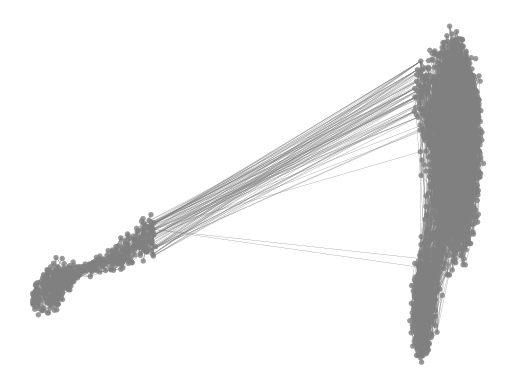

In [139]:
scv.pl.velocity_graph(adata)

Test

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class IsoveloDecoder(nn.Module):
    def __init__(self, 
                 n_cells: int, 
                 n_genes: int, 
                 n_isoforms: int, 
                 g2i_mask: torch.Tensor, 
                 latent_dim: int = 128, 
                 hidden_dim: int = 256,
                 n_steps: int = 10,  # 把时间切成10份来积分
                 init_time: np.ndarray = None,       
                 init_alpha: np.ndarray = None,      
                 init_beta_iso: np.ndarray = None,   
                 init_gamma: np.ndarray = None,      
                 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        
        super().__init__()
        self.n_genes = n_genes
        self.n_isoforms = n_isoforms
        self.n_steps = n_steps # 积分步数
        self.device = device
        
        self.register_buffer('g2i_mask', g2i_mask.float().to(device)) 

        # --- Parameters ---
        # 1. Cell Time (每个细胞独立的时间)
        if init_time is not None:
            t_init = torch.from_numpy(init_time).float().view(-1, 1)
        else:
            t_init = torch.rand(n_cells, 1) * 5.0
        self.cell_time_param = nn.Parameter(t_init)

        # 2. Gamma (常数)
        self.gamma_param = nn.Parameter(torch.zeros(1, n_isoforms))
        if init_gamma is not None:
            self.gamma_param.data.copy_(self._inverse_softplus(torch.from_numpy(init_gamma).float().unsqueeze(0)))

        # 3. Networks for Alpha/Beta (z -> parameter)
        self.alpha_fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, n_genes)
        )
        self.beta_fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, n_isoforms)
        )
        
        # Initialization logic (omitted for brevity, same as before)
        if init_alpha is not None:
            inv_alpha = self._inverse_softplus(torch.from_numpy(init_alpha).float())
            self.alpha_fc[-1].bias.data.copy_(inv_alpha)
        if init_beta_iso is not None:
            inv_beta = self._inverse_softplus(torch.from_numpy(init_beta_iso).float())
            self.beta_fc[-1].bias.data.copy_(inv_beta)

    @staticmethod
    def _inverse_softplus(x):
        return torch.log(torch.exp(x) - 1.0 + 1e-6)

    def forward(self, z_final, cell_indices):
        """
        z_final: [Batch, Latent] 细胞当前的潜在状态
        cell_indices: [Batch] 用于取时间
        """
        batch_size = z_final.shape[0]
        
        # 1. 获取这个 Batch 中每个细胞的总时间 T
        T = F.softplus(self.cell_time_param[cell_indices]) # [Batch, 1]
        
        # 2. 构造虚拟历史 (Virtual History)
        # 我们假设细胞是从 z=0 演化到 z=z_final 的
        # 我们生成 n_steps 个时间点，代表 0% T, 10% T, ... 90% T
        
        # 生成插值系数: [0, 0.1, 0.2, ..., 0.9] (假设 n_steps=10)
        steps_ratio = torch.linspace(0, 1 - 1/self.n_steps, self.n_steps, device=self.device)
        
        # 扩展 z: [Batch, Steps, Latent]
        # z_history[b, s, :] = z_final[b, :] * steps_ratio[s]
        # 这就模拟了细胞从不成熟(0)到成熟(z_final)的过程
        z_history = torch.einsum('bl,s->bsl', z_final, steps_ratio)
        
        # 3. 并行计算历史时刻的 Alpha 和 Beta
        # 输入维度: [Batch * Steps, Latent] -> 输出: [Batch * Steps, Genes]
        # 这样 alpha 就随状态(也就是随时间)变化了！
        flat_z = z_history.reshape(-1, z_final.shape[1])
        
        alpha_flat = F.softplus(self.alpha_fc(flat_z))
        beta_iso_flat = F.softplus(self.beta_fc(flat_z))
        
        # Reshape 回 [Batch, Steps, Features]
        alpha_seq = alpha_flat.reshape(batch_size, self.n_steps, self.n_genes)
        beta_iso_seq = beta_iso_flat.reshape(batch_size, self.n_steps, self.n_isoforms)
        
        # 计算 Gene level beta
        beta_gene_seq = torch.einsum('bsi,gi->bsg', beta_iso_seq, self.g2i_mask)
        
        # 获取 Gamma (constant)
        gamma = F.softplus(self.gamma_param)
        
        # 4. 数值积分 (Euler Method, 最简单直观的 delta time 累加)
        # 类似于你说的 delta time * alpha
        
        dt = T / self.n_steps # [Batch, 1] 每个 step 的时长
        
        # 初始化 u, s 为 0
        u = torch.zeros(batch_size, self.n_genes, device=self.device)
        s = torch.zeros(batch_size, self.n_isoforms, device=self.device)
        
        for i in range(self.n_steps):
            # 当前时刻的参数
            alpha_t = alpha_seq[:, i, :]
            beta_gene_t = beta_gene_seq[:, i, :]
            beta_iso_t = beta_iso_seq[:, i, :]
            
            # --- 物理方程 (Euler更新) ---
            # 这一步完全符合你的想法： u_new = u_old + dt * rate
            
            # dU = Production - Degradation
            du = alpha_t - beta_gene_t * u
            
            # dS = Splicing - Degradation
            # 注意: S的来源是 beta_iso * u_gene
            u_expanded = torch.matmul(u, self.g2i_mask)
            ds = beta_iso_t * u_expanded - gamma * s
            
            # 更新状态
            u = u + dt * du
            s = s + dt * ds
            
            # 保证非负
            u = F.relu(u)
            s = F.relu(s)
            
        return {
            "u_hat": u, 
            "s_hat": s,
            "t": T,
            "alpha": alpha_seq[:, -1, :], # 返回最后一步的alpha供参考
            "beta": beta_iso_seq[:, -1, :],
            "gamma": gamma
        }

In [11]:
import torch
import numpy as np

# 1. 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

# 2. 定义维度 (模拟小规模数据)
n_cells = 20
n_genes = 10
n_isoforms = 15
latent_dim = 128
hidden_dim = 256

# 3. 构造必要的模拟数据
# (A) Gene-to-Isoform Mask (必须项)
# 逻辑：创建一个 [Genes, Isoforms] 的矩阵，每一列(isoform)只有一个1(属于某个gene)
mask_np = np.zeros((n_genes, n_isoforms))
# 简单起见，随机给每个 isoform 分配一个 gene
for i in range(n_isoforms):
    g_idx = np.random.randint(0, n_genes)
    mask_np[g_idx, i] = 1
g2i_mask = torch.from_numpy(mask_np)

# (B) 初始化参数 (scvelo 模拟结果)
# 注意形状：Time是(n_cells,), Alpha是(n_genes,), Beta/Gamma是(n_isoforms,)
test_time = np.random.rand(n_cells) * 5.0 # 模拟时间 0-5
test_alpha = np.random.rand(n_genes)
test_beta_iso = np.random.rand(n_isoforms)
test_gamma = np.random.rand(n_isoforms)

# (C) 模拟输入 Latent z
test_z = torch.randn(n_cells, latent_dim).to(device) # [Batch, 128]

# (D) 模拟 Batch Indices (如果是全量测试，就是 range(n_cells))
# 如果是 DataLoader 里的一个 batch，这里就是该 batch 对应的索引
test_indices = torch.arange(n_cells).to(device)

# 4. 实例化 Decoder
# 注意：你需要确保你的 IsoveloDecoder 类定义在前面已经运行过
decoder = IsoveloDecoder(
    n_cells=n_cells,
    n_genes=n_genes,
    n_isoforms=n_isoforms,
    g2i_mask=g2i_mask,       # <--- 关键新增
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    n_steps=10,              # 数值积分步数
    init_time=test_time,
    init_alpha=test_alpha,
    init_beta_iso=test_beta_iso,
    init_gamma=test_gamma,
    device=device
).to(device)

# 5. 运行 Forward 测试
print("--- Starting Forward Pass ---")
try:
    # Forward 需要传入 indices 以获取对应的 Time
    outputs = decoder(test_z, test_indices)
    
    # 6. 检查输出结果
    u_hat = outputs["u_hat"]
    s_hat = outputs["s_hat"]
    pred_time = outputs["t"]
    
    print("\n✅ Forward pass successful!")
    print(f"Reconstructed U shape: {u_hat.shape} (Expected: {n_cells}, {n_genes})")
    print(f"Reconstructed S shape: {s_hat.shape} (Expected: {n_cells}, {n_isoforms})")
    print(f"Inferred Time shape:   {pred_time.shape} (Expected: {n_cells}, 1)")
    
    # 检查是否有 NaN (数值积分常见问题)
    if torch.isnan(u_hat).any() or torch.isnan(s_hat).any():
        print("⚠️ Warning: Output contains NaNs. Check initialization or learning rates.")
    else:
        print("数值检查通过: No NaNs detected.")
        
    # 查看一下实际的数据示例（确保非负）
    print(f"\nExample U_hat (first cell):\n{u_hat[0, :5].detach().cpu().numpy()}")
    
except Exception as e:
    print(f"\n❌ Error during forward pass: {e}")
    import traceback
    traceback.print_exc()

Running on: cuda
--- Starting Forward Pass ---

✅ Forward pass successful!
Reconstructed U shape: torch.Size([20, 10]) (Expected: 20, 10)
Reconstructed S shape: torch.Size([20, 15]) (Expected: 20, 15)
Inferred Time shape:   torch.Size([20, 1]) (Expected: 20, 1)
数值检查通过: No NaNs detected.

Example U_hat (first cell):
[0.98614293 0.6515614  0.70129627 1.1449945  0.72132283]


In [12]:
outputs

{'u_hat': tensor([[0.9861, 0.6516, 0.7013, 1.1450, 0.7213, 0.1793, 0.6613, 0.4312, 0.1813,
          1.5473],
         [0.6498, 0.4466, 0.5104, 0.7735, 0.5817, 0.1442, 0.5040, 0.4521, 0.1635,
          1.0480],
         [2.6094, 1.1398, 0.7589, 3.1038, 1.0989, 0.2259, 1.7275, 0.4090, 0.1932,
          3.4930],
         [1.2076, 0.7583, 0.6639, 1.5062, 0.9735, 0.2168, 0.7520, 0.4659, 0.1817,
          1.7877],
         [2.3933, 0.9522, 0.6311, 3.2229, 0.9823, 0.1757, 1.4936, 0.5275, 0.1734,
          3.6760],
         [1.1300, 0.6371, 0.7708, 1.1434, 0.6233, 0.2014, 0.6648, 0.3928, 0.1545,
          1.6125],
         [0.7795, 0.5358, 0.5507, 1.0127, 0.6285, 0.1635, 0.4810, 0.4568, 0.1901,
          1.2098],
         [1.6265, 1.0227, 0.6674, 2.0116, 0.8331, 0.2312, 1.0964, 0.5128, 0.1816,
          2.3464],
         [2.4238, 1.1571, 0.7659, 2.8902, 0.8844, 0.1796, 1.6040, 0.5028, 0.1894,
          3.5638],
         [2.2764, 1.2852, 0.6608, 2.6655, 1.0902, 0.1464, 1.7238, 0.4555, 0.1604,


In [14]:
prop = adata.obsm['proportion']
prop_keep = prop >= 0.02
iso_df = adata.obsm['isoform_counts']
iso_sums = iso_df.sum(axis=0)
keep_mask_count = iso_sums >= 500
cells_passing_count = prop_keep.sum(axis=0)
keep_passing = cells_passing_count >= 10
keep_isoforms = keep_mask_count & keep_passing
filtered_iso_df = iso_df.loc[:, keep_isoforms]


isoform_names = iso_df.columns
try:
    gene_map = pd.Series([x.rsplit('_', 1)[0] for x in isoform_names], index=isoform_names)
except Exception as e:
    raise ValueError(f"Error parsing isoform with names '_'. Error: {e}")

remaining_isoforms = gene_map[keep_isoforms.values]
new_counts = pd.Series(remaining_isoforms).value_counts(sort=False)

adata.var['filtered_n_isoforms'] = 0
genes_to_update = new_counts.index.intersection(adata.var_names)
adata.var.loc[genes_to_update, 'filtered_n_isoforms'] = new_counts[genes_to_update]

adata_hvg = adata.copy()

sc.pp.normalize_total(adata_hvg)
sc.pp.log1p(adata_hvg)
sc.pp.highly_variable_genes(adata_hvg, n_top_genes=500, flavor='seurat')
hvg_genes = set(adata_hvg.var_names[adata_hvg.var['highly_variable']])

relevant_genes = gene_map[filtered_iso_df.columns].unique()

gene_to_iso_cols = {}
current_iso_cols = filtered_iso_df.columns
temp_gene_map = gene_map[current_iso_cols]
    
for iso, gene in temp_gene_map.items():
    if gene not in gene_to_iso_cols:
        gene_to_iso_cols[gene] = []
    gene_to_iso_cols[gene].append(iso)

current_gene_map = pd.Series([x.rsplit('_', 1)[0] for x in current_iso_cols], index=current_iso_cols)
new_gene_counts_df = filtered_iso_df.groupby(current_gene_map.values, axis=1).sum()
adata.layers['spliced'] = new_gene_counts_df.values
adata.X = adata.layers['spliced'] + adata.layers['unspliced']

gene_ids_per_col = current_gene_map[filtered_iso_df.columns]
gene_counts_expanded = new_gene_counts_df.loc[:, gene_ids_per_col]
gene_counts_expanded.columns = filtered_iso_df.columns 
 
new_props = filtered_iso_df / (gene_counts_expanded)
iso_variances = new_props.var(axis=0)
gene_splicing_scores = iso_variances.groupby(current_gene_map.values, sort=False).mean()

multi_iso_genes = adata.var_names[adata.var['filtered_n_isoforms'] > 1]
valid_genes = gene_splicing_scores.index.intersection(multi_iso_genes)
final_scores = gene_splicing_scores.loc[valid_genes]

if not final_scores.empty:
    top_splicing_genes = final_scores.sort_values(ascending=False).head(250).index.tolist()
    high_splice_genes = set(top_splicing_genes)
else:
    high_splice_genes = set()
        
print(f"Identified {len(high_splice_genes)} genes with high splicing variance.")
final_genes_set = (hvg_genes | high_splice_genes)
final_genes = [gene for gene in adata.var_names if gene in final_genes_set]

is_isoform_kept = current_gene_map.isin(final_genes_set)
    
final_iso_counts = filtered_iso_df.loc[:, is_isoform_kept]
final_iso_props  = new_props.loc[:, is_isoform_kept]

Identified 250 genes with high splicing variance.


In [22]:
adata.obsm['proportion']

,gene0_isoform0,gene0_isoform1,gene0_isoform2,gene0_isoform3,gene0_isoform4,gene1_isoform0,gene1_isoform1,gene1_isoform2,gene2_isoform0,gene2_isoform1,...,gene997_isoform0,gene997_isoform1,gene998_isoform0,gene998_isoform1,gene998_isoform2,gene999_isoform0,gene999_isoform1,gene999_isoform2,gene999_isoform3,gene999_isoform4
cell0,0.002771,0.000183,0.055434,0.783882,0.157730,0.092371,0.019413,0.888215,0.012982,0.935811,...,0.025368,0.974632,0.039979,0.949587,0.010434,0.013327,0.008082,0.897071,0.038516,0.043005
cell1,0.069436,0.027645,0.038120,0.711690,0.153109,0.011709,0.150345,0.837946,0.031030,0.945185,...,0.041177,0.958823,0.024048,0.907134,0.068818,0.044004,0.076466,0.793215,0.060215,0.026101
cell2,0.036947,0.099650,0.039248,0.821082,0.003073,0.019592,0.000135,0.980273,0.006178,0.967000,...,0.168463,0.831537,0.061806,0.929543,0.008651,0.042498,0.004834,0.907459,0.024848,0.020361
cell3,0.011987,0.062847,0.021297,0.891863,0.012006,0.124549,0.013793,0.861658,0.005194,0.921849,...,0.000429,0.999571,0.036014,0.906556,0.057429,0.080205,0.022818,0.845171,0.019799,0.032007
cell4,0.027065,0.005179,0.049520,0.912792,0.005445,0.011394,0.007370,0.981235,0.129561,0.869357,...,0.012906,0.987094,0.020643,0.940613,0.038743,0.040638,0.100550,0.802722,0.038924,0.017165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell1995,0.027365,0.004360,0.055163,0.787518,0.125594,0.138441,0.098001,0.763558,0.083523,0.898684,...,0.846623,0.153377,0.005166,0.227879,0.766956,0.033292,0.100374,0.150069,0.050855,0.665410
cell1996,0.051143,0.027791,0.000495,0.870665,0.049907,0.010933,0.008555,0.980512,0.088887,0.907819,...,0.038461,0.961539,0.071915,0.886500,0.041585,0.040483,0.017764,0.804311,0.082368,0.055074
cell1997,0.035424,0.027809,0.029545,0.888807,0.018415,0.131065,0.004510,0.864425,0.098264,0.833042,...,0.038984,0.961016,0.035882,0.937306,0.026813,0.008932,0.003378,0.814616,0.154557,0.018516
cell1998,0.038887,0.011101,0.057584,0.861432,0.030996,0.009846,0.026444,0.963710,0.076589,0.886500,...,0.138428,0.861572,0.005505,0.802444,0.192051,0.015179,0.015678,0.766043,0.048797,0.154303


In [11]:
gene_splicing_scores[750:]

gene750    0.0
gene751    0.0
gene752    0.0
gene753    0.0
gene754    0.0
          ... 
gene995    0.0
gene996    0.0
gene997    0.0
gene998    0.0
gene999    0.0
Length: 250, dtype: float64